## Access Glider ANFOG NRT data in Parquet

A jupyter notebook to show how to access and plot Glider ANFOG NRT data available as a [Parquet](https://parquet.apache.org) dataset on S3

In [1]:
dataset_name = "slocum_glider_delayed_qc"

## Install/Update packages and Load common functions

In [ ]:
# only run once, then restart session if needed
!pip install -r https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/notebooks/requirements.txt

In [2]:
import requests
import os
if not os.path.exists('parquet_queries.py'):
  print('Downloading parquet_queries.py')
  url = 'https://raw.githubusercontent.com/aodn/aodn_cloud_optimised/main/aodn_cloud_optimised/lib/ParquetDataQuery.py'
  response = requests.get(url)
  with open('parquet_queries.py', 'w') as f:
      f.write(response.text)

In [3]:
from parquet_queries import create_time_filter, create_bbox_filter, query_unique_value, plot_spatial_extent, get_spatial_extent, get_temporal_extent, get_schema_metadata
import pyarrow.parquet as pq
import pyarrow.dataset as pds
import pyarrow as pa
import os
import pandas as pd
import pyarrow.compute as pc

/home/lbesnard/miniforge3/envs/AodnCloudOptimised/lib/python3.12/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


## Location of the parquet dataset

In [4]:
BUCKET_OPTIMISED_DEFAULT="imos-data-lab-optimised"
dname = f"s3://{BUCKET_OPTIMISED_DEFAULT}/cloud_optimised/cluster_testing/{dataset_name}.parquet/"
parquet_ds = pq.ParquetDataset(dname,partitioning='hive')

# Understanding the Dataset

## Get partition keys
Partitioning in Parquet involves organising data files based on the values of one or more columns, known as partition keys. When data is written to Parquet files with partitioning enabled, the files are physically stored in a directory structure that reflects the partition keys. This directory structure makes it easier to retrieve and process specific subsets of data based on the partition keys.

In [5]:
dataset = pds.dataset(dname, format="parquet", partitioning="hive")

partition_keys = dataset.partitioning.schema
print(partition_keys)

deployment_code: string
timestamp: int32
polygon: string


## List unique partition values

In [6]:
%%time
unique_partition_value = query_unique_value(parquet_ds, 'deployment_code')
print(list(unique_partition_value)[0:2])  # showing a subset only

['Pilbara20130709', 'Kimberley20130925']
CPU times: user 4.39 ms, sys: 261 µs, total: 4.65 ms
Wall time: 3.95 ms


## Visualise Spatial Extent of the dataset
In this section, we're plotting the polygons where data exists. This helps then with creating a bounding box where there is data

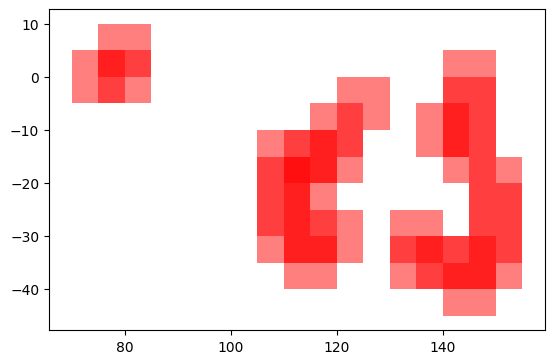

In [7]:
plot_spatial_extent(parquet_ds)

## Get Temporal Extent of the dataset

Similary to the spatial extent, we're retrieving the minimum and maximum timestamp partition values of the dataset. This is not necessarely accurately representative of the TIME values, as the timestamp partition can be yearly/monthly... but is here to give an idea

In [8]:
get_temporal_extent(parquet_ds)

(datetime.datetime(2008, 4, 1, 11, 0), datetime.datetime(2024, 4, 1, 11, 0))

## Read Metadata

For all parquet dataset, we create a sidecar file in the root of the dataset named **_common_matadata**. This contains the variable attributes.

In [9]:
# parquet_meta = pa.parquet.read_schema(os.path.join(dname + '_common_metadata'))  # parquet metadata
metadata = get_schema_metadata(dname)  # schema metadata
metadata

{'PLATFORM': {'type': 'string',
  'trans_system_id': 'Irridium',
  'positioning_system': 'GPS',
  'platform_type': 'Slocum G2',
  'platform_maker': 'Teledyne Webb Research',
  'firmware_version_navigation': 7.1,
  'firmware_version_science': 7.1,
  'glider_serial_no': '416',
  'battery_type': 'Alkaline',
  'glider_owner': 'CSIRO',
  'operating_institution': 'ANFOG',
  'long_name': 'platform informations'},
 'DEPLOYMENT': {'type': 'string',
  'deployment_start_date': '2015-10-21-T05:00:02Z',
  'deployment_start_latitude': -18.9373,
  'deployment_start_longitude': 146.881,
  'deployment_start_technician': 'Gregor, Rob',
  'deployment_end_date': '2015-10-27-T01:56:23Z',
  'deployment_end_latitude': -19.2358,
  'deployment_end_longitude': 147.5188,
  'deployment_end_status': 'recovered',
  'deployment_pilot': 'pilot, CSIRO',
  'long_name': 'deployment informations'},
 'SENSOR1': {'type': 'string',
  'sensor_type': 'CTD',
  'sensor_maker': 'Seabird',
  'sensor_model': 'GPCTD',
  'sensor_ser

# Data Query and Plot

## Create a TIME and BoundingBox filter

In [10]:
filter_time = create_time_filter(parquet_ds, date_start='2020-12-01', date_end='2023-01-01')
filter_geo = create_bbox_filter(parquet_ds, lat_min=-34, lat_max=-28, lon_min=140, lon_max=160)


filter = filter_geo & filter_time

In [11]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5035724 entries, 0 to 5035723
Data columns (total 62 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   PLATFORM                   object        
 1   DEPLOYMENT                 object        
 2   SENSOR1                    object        
 3   SENSOR2                    object        
 4   SENSOR3                    object        
 5   SENSOR4                    object        
 6   LATITUDE                   float64       
 7   LATITUDE_quality_control   float32       
 8   LONGITUDE                  float64       
 9   LONGITUDE_quality_control  float32       
 10  TIME                       datetime64[ns]
 11  TIME_quality_control       float32       
 12  HEAD                       float64       
 13  HEAD_quality_control       float32       
 14  UCUR                       float64       
 15  UCUR_quality_control       float32       
 16  VCUR                       float64  

## Create a TIME and scalar/number filter

In [12]:
filter_time = create_time_filter(parquet_ds, date_start='2024-01-01', date_end='2024-05-01')

expr_1 = pc.field('deployment_code') == pa.scalar("MissionBeach20240120")
filter = expr_1 & filter_time

In [13]:
%%time
# using pandas instead of pyarrow so that filters can directly be applied to the data, and not just the partition
df = pd.read_parquet(dname, engine='pyarrow',filters=filter)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228684 entries, 0 to 228683
Data columns (total 62 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   PLATFORM                   228684 non-null  object        
 1   DEPLOYMENT                 228684 non-null  object        
 2   SENSOR1                    228684 non-null  object        
 3   SENSOR2                    228684 non-null  object        
 4   SENSOR3                    228684 non-null  object        
 5   SENSOR4                    228684 non-null  object        
 6   LATITUDE                   228684 non-null  float64       
 7   LATITUDE_quality_control   228684 non-null  float32       
 8   LONGITUDE                  228684 non-null  float64       
 9   LONGITUDE_quality_control  228684 non-null  float32       
 10  TIME                       228684 non-null  datetime64[ns]
 11  TIME_quality_control       228684 non-null  float32 

<Axes: title={'center': 'Temperature for each location'}, xlabel='LONGITUDE', ylabel='LATITUDE'>

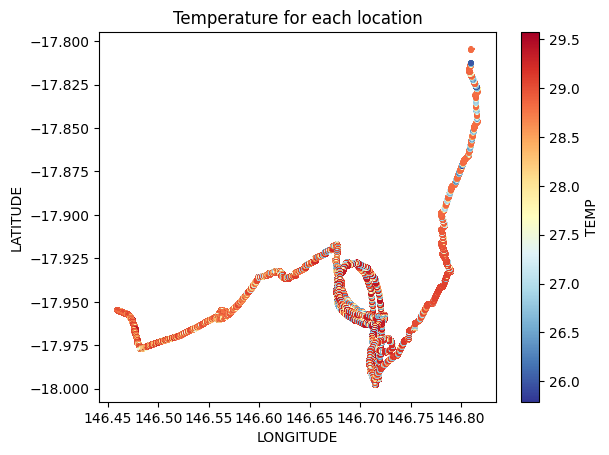

In [14]:
df.plot.scatter(x='LONGITUDE', y='LATITUDE', c='TEMP', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature for each location')

/tmp/ipykernel_1206422/1403522444.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


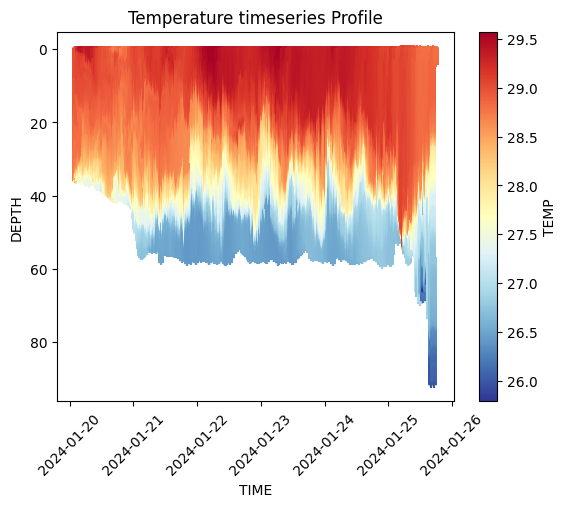

In [15]:
import matplotlib.pyplot as plt
ax = df.plot.scatter(x='TIME', y='DEPTH', c='TEMP', marker='+', linestyle="None", cmap='RdYlBu_r', title='Temperature timeseries Profile')

ax.invert_yaxis()

# Rotate x-axis labels at 45 degrees
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# Show the plot
plt.show()